In [411]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

### Testing Autocorrelation: 
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from scipy.stats import jarque_bera

### Unit Root Testing
from statsmodels.tsa.stattools import adfuller

### Introduction

Once a model has been specified, a range of __diagnostic tools__ are available for __checking its adequacy__.

Many of them are __based on the model residuals__. 

We will see some graphical tools for checking the residuals, and then turn some tests to __investigate specific properties of the residuals__.

Then we can also test if __the model is robust and stable (estimate the model rescurisvely for different subsamples)__.

### 1. Descriptive Tools

Plotting the residuals series of a time series model is an important way to detect possible model deficencies. For example, outliers, inhomogeneous variances may show up. 

#### Z-Score

For spotting __unusual residuals__ a Z-Score may be useful before plotting them. Denoting the residual series by $\hat{u}_t$, we obtain the Z-Score as: 

$$Z_t(\hat{u}) = \frac{\hat{u}_t - \overline{\hat{u}}}{\tilde{\sigma}_u}$$

If the residuals are normally distributed with zero mean, roughly 95% of the Z-Scores values should be in a band of $\pm 2$ around the zero line.

#### ACF and PACF

ACF and PACF __contain information about serial dependence in the residuals__.

__Autocorrelations of the squared residuals__ may be informative about possible __conditional heteroskedasticity__ (*propagacion/relacion de errores del pasado en el presente, falta de independencia entre ellos*). 

ACF and PACF associated with low lags that reach outside the $\pm \frac{2}{\sqrt{T}}$ (*intervalo de confianza utilizado alrededor del cero*) are suspicious and give rise to concern about the adequacy of the model. 

#### Plot Estimated Density

Residuals estimated density may be determined by __using a kernel estimator of the form__

$$\hat{f}_h(u) = (Th)^{-1}\sum_{t = 1}^{T}K\left(\frac{u - Z_t(\hat{u})}{h}\right)$$

where $h$ is the __bandwith__ or __window width__ and $K(.)$ is a __kernel function__, which is tipically a symmetric pdf, for example, 

$$K(u) = (2\pi)^{-1/2}exp(-u^2/2)$$

may be used. 

### Example Plotting Descriptive Tools

<AxesSubplot:>

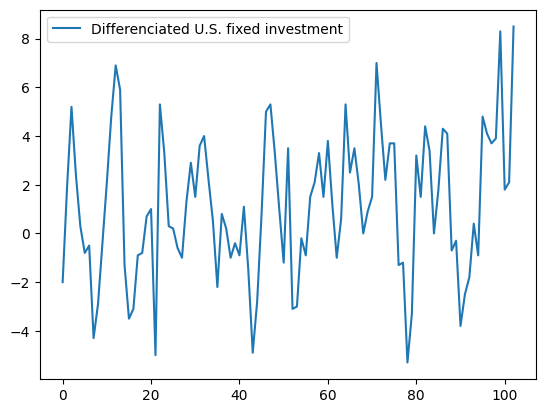

In [342]:
#Building long-term interest rates Dataframe ##########################
url_1 = "http://www.jmulti.de/download/datasets/US_investment.dat"
df  = pd.read_csv(url_1, on_bad_lines='skip', encoding='cp1252').iloc[:,:1]
df = df.iloc[:,0].str.split()[7:]
L = [[float(number) for number in element.split()][0] for element in list(df.index)]
df_inv= pd.DataFrame(columns = ["Differenciated U.S. fixed investment"])
df_inv["Differenciated U.S. fixed investment"] = L
df_inv.plot()

In [343]:
#res = AutoReg(df_inv, 4, old_names=False).fit()
#res.summary()

In [344]:
def akaike(data, pmax, plotting = True):
    """
    data: Time Series
    pmax: Maximum order of the model
    
    return: Minimum value of Akaike information criterion. 
    """
    output = dict()
    for n in range(1, pmax+1):
        res = AutoReg(data, n, old_names=False).fit()
        output[n] = res.aicc
    df = pd.DataFrame(data = list(output.values()), index = list(output.keys()))
    if plotting:
        plt.plot(df.idxmin(axis = 0), df.min(axis = 0), marker="o", markeredgecolor="red", markerfacecolor="red")
        plt.plot(df.index,df.values, 'b')
        plt.xlabel("Order of AR Model")
        plt.ylabel("Information Coefficient Score")
    
    return df.idxmin(axis = 0)[0]

#### Plotting Residuals
First step, looking at the residuals. 

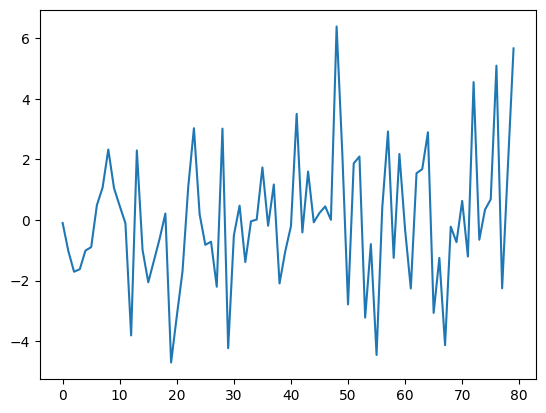

In [345]:
recommended_order = akaike(df_inv, 40, plotting = False)
res = AutoReg(df_inv, recommended_order, old_names=False).fit()
example = res.resid
plt.plot(list(example.values))

#### Z-Score plotting example

It seems that around 95% of the residuals are inside $\pm 2$ band. 

In [346]:
def Z_Score(S, plotting = True):
    """
    Function returning Z-Scores of residuals time-series.
    
    Parameters: 
    
    S: Time Series (in this case residuals serie)
    """
    m = S.mean()
    sd = S.std()
    output = [(element - m)/sd for element in S.values]
    if plotting:
        plt.plot(S.index,output, 'b')
        plt.xlabel("Observation")
        plt.ylabel("Z-Score")
        plt.axhline(y = -2, color='r', ls = "--")
        plt.axhline(y = 2, color='r', ls = "--")
    return output

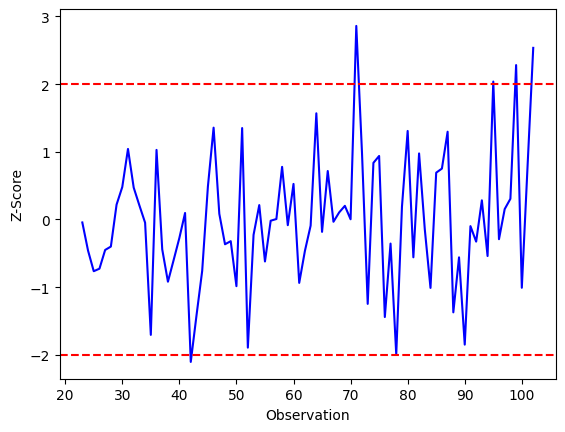

In [347]:
z = Z_Score(example)

#### Estimation Density Function

Immportant to know there exists a function in pandas: __Series.plot.kde()__ giving to us the plot of the estimated density of pandas series. 

In this case it seems normal distributed

<AxesSubplot:ylabel='Density'>

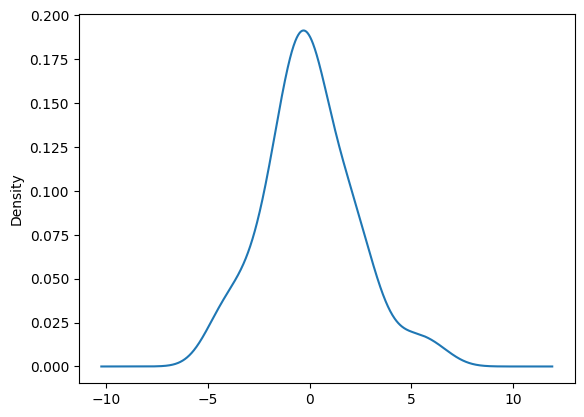

In [348]:
example.plot.kde()

### 2. Statistical Tests on Residuals

#### 2.1 Portmanteau test: Residual Autocorrelation 

<u>From Wikipedia:</u> Two well-known versions of a portmanteau test are available for testing for autocorrelation in the residuals of a model: __it tests whether any of a group of autocorrelations of the residual time series are different from zero.__ 

This test is the __Ljung–Box test__, which is an improved version of the Box–Pierce test,having been devised at essentially the same time; a seemingly trivial simplification (omitted in the improved test) was found to have a deleterious effect.This portmanteau test is useful in working with ARIMA models.

- $H_0: \rho_{u, 1} = \ldots = \rho_{u, h} = 0$
- $H_1: \rho_{u, i} \neq 0 \text{ for at least one } i = 1, 2, \ldots, h$

The null hypotesis is rejected for large values of the test statistic. 

Remaining residual autocorrelation indicates a model defect. Try models with larger order.

#### 2.2 LM test: Residual Autocorrelation in AR models

This test is based on considering an AR(h) model for the residuals

$$u_t = \beta_1u_{t-1} + \ldots + \beta_hu_{t-h}$$

and checking the pair of hypothesis, 

- $H_0: \beta_{1} = \ldots = \beta_{h} = 0$
- $H_1: \beta_{i} \neq 0 \text{ for at least one } i = 1, 2, \ldots, h$

If the original model is an AR(p),

$$y_t = \nu + \alpha_1y_{t-1} + \ldots + \alpha_py_{t-p}$$

The auxiliary model, 

$$\hat{u}_t = \nu + \alpha_1y_{t-1} + \ldots + \alpha_py_{t-p} + \beta_1\hat{u}_{t-1} + \ldots + \beta_h\hat{u}_{t-h} + e_t$$

is fitted. 

Test statistic (with $R^2$ the coefficient of determination of the auxiliary model), 

$$LM_h = TR^2$$

In the absence of residual correlation it has a $\chi^2(h)$ ditributoin. The null hypothesis is rejected if $LM_h$ is large and exceeds the critical value from the $\chi^2(h)$. 

#### 2.3 Jarque-Bera test: Nonnormality

Test for __nonnormality based on the thirs and fourth moment, or in other words, skewness and kurtosis of a distribution__.

Dennoting by $Z_t$ the Z-Score on true model residuals, (i.e, $Z_t = \frac{u_t}{\sigma_u}$), the test checks the pair of hypothesis 

- $H_0: \mathbb{E}(Z_t^3) = 0 \text{ and } \mathbb{E}(Z_t^4) = 3$
- $H_1: \mathbb{E}(Z_t^3) \neq 0 \text{ or } \mathbb{E}(Z_t^4) \neq 3$

The test statistic has an asymptotic $\chi^2(2)$ distribution if the null hypothesis is correct, and the null hypothesis is rejected if test statistic is large. 

##### Test Interpretation

- If $H_0$ is rejected, normal distribution is also rejected. 
- If $H_0$ holds, this does not necessarily mean that the underlying distribution is normal, just that __the underlying distribution has the same first four moments as the normal distribution__. However, deviations beyond thatmay not be important. 

Nonnormal residuals can be a consequence of neglected nonlinearities for example. 

Sometimes, taking into account $ARCH$ effects may help. An __ARCH test is therefore also performed routinely in model checking.__

#### 2.4 LM test: ARCH

A popular test for __neglected heteroskedasticity, or, birefly, for ARCH__ is based on fitting an $ARCH(q)$ model to the estimation residuals. 

$$\hat{u}_t^2 = \beta_0 + \beta_1\hat{u}_{t-1}^2 + \ldots + \beta_h\hat{u}_{t-h}^2 + e_t$$

and checking the pair of hypothesis, 

- $H_0: \beta_{1} = \ldots = \beta_{h} = 0$
- $H_1: \beta_{i} \neq 0 \text{ for at least one } i = 1, 2, \ldots, h$

#### 2.5 RESET test

Useful for __testing a given model against general unspecified alternatives__.


### Statistical Tests: Example

#### Ljung-Box Test: Residual Serial Autocorrelation 

In [349]:
acorr_ljungbox(example, lags=[element for element in range(10,30,2)], return_df=True)


,lb_stat,lb_pvalue
10,1.163820,0.999656
12,1.221180,0.999957
14,1.609070,0.999979
16,4.528228,0.997645
18,4.998833,0.998862
20,6.962230,0.996807
22,8.109892,0.996857
24,8.294912,0.998762
26,8.670279,0.999425
28,9.937741,0.999342


We can see that *p-value* is always high, no need to have any concern in autocorrelation. However, we will perform an LM test. This LM test is also known as __Breusch - Godfrey test__.

In [350]:
acorr_breusch_godfrey(res, nlags=6)[1]

0.9999602189621031

Now we will test if __residuals are following a normal distribution__ for this, as described above, we will perform a __Jarque-Bera Test__.

In [351]:
jarque_bera(example)

Jarque_beraResult(statistic=2.3354520154834146, pvalue=0.31107351635581804)

### 3. Stability Analysis

Another important way to check a model is to __investigate its stability over time__.
For this purpose, __estimates for different subperiods__ are usually computed and examined. __Chow tests__ offer a formal way to do this. Thereafter, recursive analysis, which investigates the estimator variability for successively extended samples, is discussed. We will assume that the underlying model is an $AR(p)$ process with deterministic term. 

#### 3.1 Chow Tests

Classical tool for testing for structural change. We have different variants: *sample-split, break-point and forecasts tests*. 

These tests are based on the assumption that a __structural break__ may have occured in period $T_B$. 

__Sample-Split and Break-Point tests compare estimates from the observations associated with the period before $T_B$ with those obtained after $T_B$__. More precisely, the model is estimated by OLS from the full sample T as well as from the first $T_1$ and last $T_2$ observations such that $T_1 < T_B$ and $T_2 < T-T_B$. 

The test statistics will compare the residual variance estimate from a constant coefficient model with the residual variance estimate of a model that allows for a change in the parameters. 

*Es decir, compararemos la varianza de los residuos del modelo general con la varianza de los residuos en un modelo antes del cambio estrictural y despues del cambio estructural.*

- Sample-Split: Checks the null hypothesis that the AR coefficients and deterministic terms do not change during sample period. 
- Break-Point: Checks in addition the constancy of the white noise variance. 
- Forecast: Compares the full sample residual variance with the residual variance for the first subperiod. I.e, it checks wheter forecasts from the model fitted to the first subsample are compatible with the observations in the second subsample. 

__These three tests may be performed repeatedly for a range of potential break points $T_B$ , the results may be plotted. 

*Testeas si hay cambios estructurales en diferentes puntos. Luego solamente coges el maximo de la estadistica de test para todos los posibles puntos de cambio estructural ($T_B$), recordemos que buscamos que esta estadistica sea lo menos grande posible, por lo tanto cogemos el "peor" de los valores.*

Looking for 
$$\sup_{T_B \in T} \lambda_{SS} \text{ (where } \lambda_{SS} \text{ is the test statistic) }$$

is useful if __the timing of a possible break point is unknown.__

<u>Wikipedia Info:</u> https://en.wikipedia.org/wiki/Chow_test

#### 3.2 Recursive Analysis

Many recursive statistics are often computed to get an impression of the stability of a model through time. For this purpose, __the model is estimated using only data for $t = 1, \ldots ,\tau$__ and letting $\tau$ run from $T_1$ to $T$. 

We can plot the estimates and estimated confidence intervals for different $\tau$ values. 

Also, the series of __recursive residuals__, that is, the series of standardized one-step forecast errors from a model estimated on the basis of data up to period $\tau + 1$. 

More precisely, for a linear model $y_t = x_t^T\beta + u_t\; (t = 1 \ldots, T)$ and $\hat{\beta}_{(\tau)}$ denoting the OLS estimator based on the first $\tau$ observations only, that is, 

$$\hat{\beta}_{(\tau)} = \left(\sum_{t = 1}^{\tau} x_tx_t^T\right)^{-1}\sum_{t = 1}^{\tau} x_ty_t$$

Recall the notation,
$$x_t = 
\begin{bmatrix}
x_{1,t}\\
\ldots\\
x_{K,t}
\end{bmatrix}
$$

Where $K$ is the number of explanatory variables.

We define the recursive residuals as, 

$$\hat{u}_{\tau}^{(r)} = \frac{y_{\tau} - x_{\tau}^T \hat{\beta}_{(\tau - 1)}}{\left(1 + x_{\tau}^T \left(\sum_{t = 1}^{\tau - 1} x_tx_t^T\right)^{-1}x_{\tau}\right)^{1/2}}$$

*En el numerador tenemos basicamente el error de forecast en $\tau$ dadas las observaciones de $t= 1$ a $\tau - 1$. Lo del denominador es un factor de normalizacion para que la varianza de este error sea simple.*

*Para echar un ojo en distribuciones del estimador OLS: https://gregorygundersen.com/blog/2021/08/26/ols-estimator-sampling-distribution/*

Here, __the recursive residuas have constant variance $\sigma_u^2$.__

Below, we can see a method storing recursive residuals of an AR model. Also, the parameter *plotting_mode* is available in order to plot the recursive residuals time series.


#### CUSUM tests

<u>Definition:</u> The so-called CUSUM, that is, __the cumulative sum of recursive residuals__, can also reveal structural changes in and is therefore plotted for $\tau = K + 1 \ldots + T$ in checking a model. 

$$CUSUM_\tau = \sum_{t = K+1}^{\tau}\frac{\hat{u}^{(r)}_t}{\hat{\sigma}_u}$$

If the CUSUM wanders off too far from the zero line, this is evidence against a structural stability of the underlying model. 

A test with a significance level of about $5%$ is obtained by __rejecting stability if $CUSUM_{\tau}$ crosses the line $\pm 0.948\left[\sqrt{T - K} + 2\frac{(\tau - K)}{\sqrt{T - K}}\right]$

*Basicamente la stadistica CUSUM es una suma de elementos de media cero (el error de forecast tiene media 0), por lo que no puede alejarse demasiado del nivel 0.*

Look at page 53 (Applied Time Series Econometrics - Lütkepohl & Krätzig) for CUSUM-of-squares

In [409]:
def recursive_residuals(data, order_model = 4, minimum_observation = 6, plotting_mode = False):
    
    """
    Method storing recursive residuals as presented above (standardized one-step forecast error). 
    
    Params: 
    
    Data: Time-Series
    Order_model: Order of the AR model we are willing to test
    minimum_observation: From which observation we are going to start the recursion
    plotting_mode: If we want to plot the residuals
    
    Output: 
    
    r_list: Array containing the recursive residuals. 
    """
    res = AutoReg(data, recommended_order, old_names=False).fit()
    v = res.resid.std()
    sum_residuals = 0
    cusum = list()
    cusum_inf = list()
    cusum_sup = list()
    x_dot = np.zeros((order_model+1, order_model+1))
    r_list = list()
    #First of all we put in place the explanatory variables of the autoregressive models
    for element in range(1, order_model + 1): 
        data[f"Shifted {element}"] = data.iloc[:, 0].shift(element)
    for tau in range(minimum_observation, data.shape[0]):
        if tau == minimum_observation:
            for t in range(order_model, tau-1):
                x_t = data.iloc[t, 1:].to_numpy()
                x_t = np.insert(x_t, 0, 1).reshape(order_model+1, 1)
                x_dot = x_dot + np.dot(x_t, x_t.T)
        #To compute forecast errors we want parameters at tao - 1. 
        res = AutoReg(data.iloc[:tau - 1, 0], order_model, old_names=False).fit()
        params  =res.params.to_numpy().reshape(order_model + 1, 1)
        #res.summary()
        x_tau = data.iloc[tau, 1:].to_numpy()
        #We add the element associated with constant
        x_tau = np.insert(x_tau, 0, 1).reshape(order_model+1, 1)
        y_tau = data.iloc[tau, 0]
        r = float((y_tau - np.dot(x_tau.T , params))/(1 + np.dot(np.dot(x_tau.T,(np.linalg.inv(x_dot))), x_tau)))
        sum_residuals += r/v
        cusum.append(sum_residuals)
        cusum_inf.append(-0.948*(math.sqrt(data.shape[0] - order_model) + 2*(tau - order_model)/(math.sqrt(data.shape[0] - order_model))))
        cusum_sup.append(0.948*(math.sqrt(data.shape[0] - order_model) + 2*(tau - order_model)/(math.sqrt(data.shape[0] - order_model))))
        r_list.append(r)
    if plotting_mode: 
        fig, axs = plt.subplots(2, figsize=(10, 10))
        fig.suptitle('Recursive Residuals and CUSUM time series')
        axs[0].plot(r_list)
        axs[1].plot(cusum, color = "dodgerblue")
        axs[1].plot(cusum_inf, color = "orangered", ls = "--")
        axs[1].plot(cusum_sup, color = "orangered", ls = "--")
        axs[0].axhline(v,color='r', ls = "--" )
        axs[0].axhline(-v,color='r', ls = "--" )
    return r_list, cusum

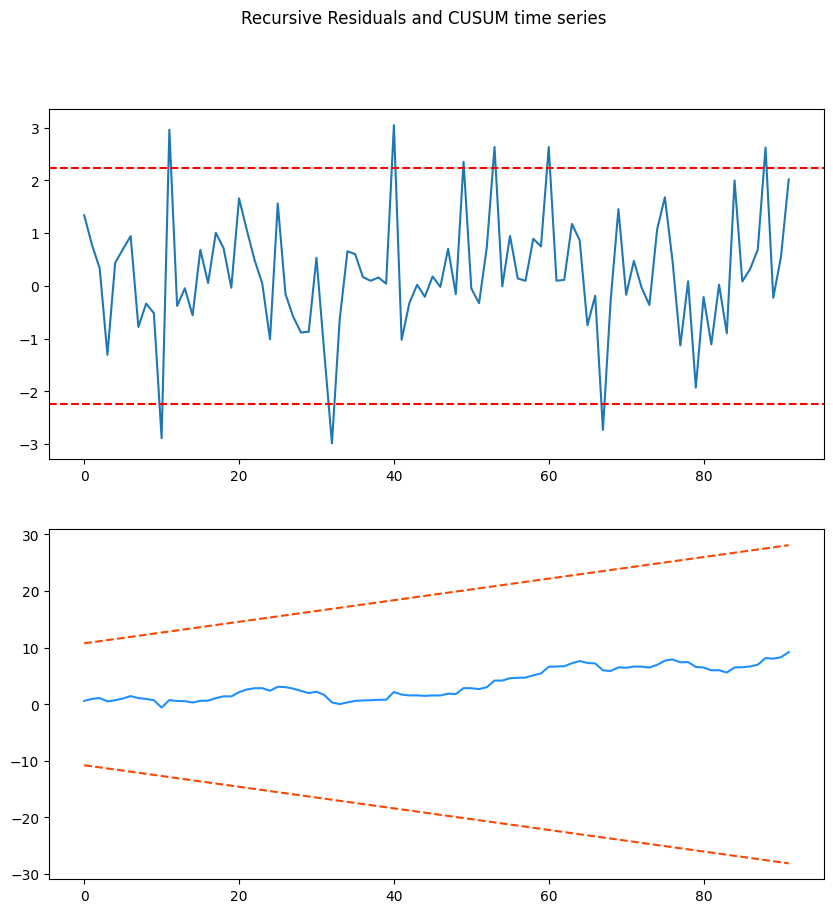

In [410]:
d = df_inv.copy()
r_list, cusum= recursive_residuals(d, order_model = 4, minimum_observation = 11, plotting_mode = True)

### 4. Unit Root Tests

<u>Indication:</u> A good review of unit root tests is given by __Stock (1994)__. 

#### 4.1 Augmented Dickey-Fuller Test

If the process is an $AR(p)$, __the process is integrated when $\alpha(1) = 0$(1 is a root of the charasteristic equation)__. 

In other words, a hypothesis of interest is $\alpha(1) = 0$. This is what the Augmented Dickey-Fuller test do (Look at page 54 *Applied Time Series Econometrics - Lütkepohl & Krätzig*).
- Null Hypo: Unit root
- Alternative Hypo: No unit root, stationarity. 

##### How to use this kind of tests? 

In general, if the order of integration of a time series and, hence, the number of unit roots in the AR operator, are not clear, __one should difference the series first as many times as deemed appropiate for making it stationnary__. Then, a unit root test is performed for the differencied series. 

For example, if $y_t$ is suspected to be $I(2)$, then a unit root test is tested for $\Delta^2y_t$ first. If the null hypotesis is rejected and is not rejected for $\Delta y_t$ this result confirms that $y_t$ is best modeled as an $I(2)$ process. 

If p-value is less than 0.05, $H_0$ can be rejected$

In [421]:
p_value = adfuller(d.iloc[:, 0].tolist())[1]
print("The p-Value of ADF test is: ", p_value)

The p-Value of ADF test is:  8.12250127631154e-07


#### 4.2 Schmidt-Phillips Tests

Variant of tests for the null hypothesis of a unit root __when deterministic linear trend is present__. 

